# Conditional likelihoods of trajectories

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from scipy import stats, interpolate
from numba import guvectorize,float64

import os
import glob
import importlib

from analyzer import analyzer, configuration

In [2]:
matplotlib.rc_file_defaults()

In [4]:
outpath = os.path.expandvars(configuration.get()['mutual_information']['output'])
num_signals = configuration.get()['mutual_information']['num_signals']
paths = glob.glob(os.path.join(outpath, '*.npy'))
mutual_informations = np.concatenate([np.load(p) for p in paths])
num_r, _, length = mutual_informations.shape
mutual_informations.shape, outpath

((1500, 2, 5000), '/home/ipausers/reinhardt/run18')

In [5]:
x = mutual_informations[0,0]
mi = np.zeros((num_r, len(x)))
for i, old in enumerate(mutual_informations):
    mi[i] = old[1]
mi_mean = np.mean(mi, axis=0)
x,mi_mean

(array([9.9999998e-03, 1.0023057e-02, 1.0046167e-02, ..., 9.9540448e+02,
        9.9769958e+02, 1.0000000e+03], dtype=float32),
 array([0.07759357, 0.07759262, 0.07759262, ..., 1.91304167, 1.91132292,
        1.91782292]))

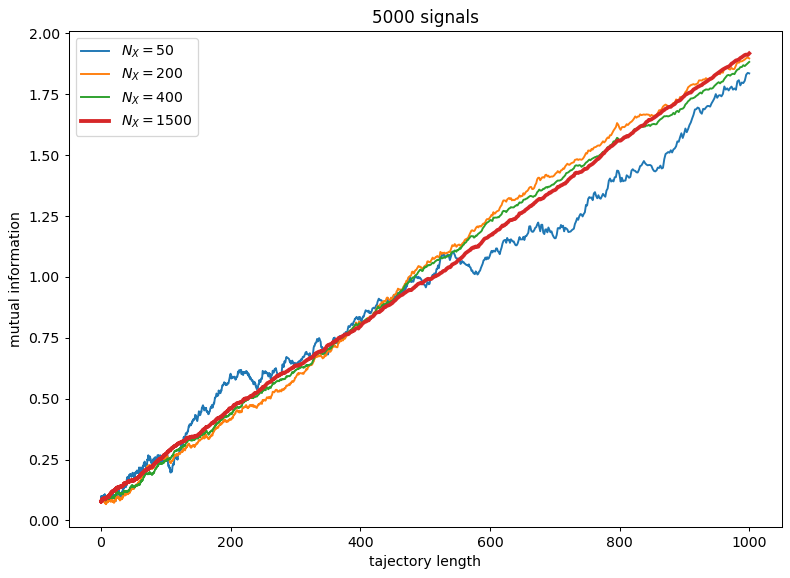

In [6]:
for r in [50, 200, 400]:
    subset_mean = np.mean(mi[:r], axis=0)
    plt.plot(x, subset_mean, label='$N_X={}$'.format(r))
plt.plot(x, mi_mean, label='$N_X={}$'.format(num_r), linewidth=3)
plt.legend()
plt.title('{} signals'.format(num_signals))
plt.ylabel('mutual information')
plt.xlabel('tajectory length');

In [7]:
numerical_x = np.array([6.10351562e-01, 1.22070312e+00, 2.44140625e+00, 4.88281250e+00,
       9.76562500e+00, 1.95312500e+01, 3.90625000e+01, 7.81250000e+01,
       1.56250000e+02, 3.12500000e+02, 6.25000000e+02, 1.25000000e+03,
       2.50000000e+03])
numerical = np.array([0.07155042, 0.07221034, 0.07352942, 0.07616464, 0.08142376,
       0.09190024, 0.1127109 , 0.15391634, 0.23541893, 0.39725253,
       0.72029812, 1.36630923, 2.65833046])

In [8]:
def mut_inf(lamda, rho):
    return lamda/2 * (np.sqrt(1 + rho/lamda) - 1)
from scipy.optimize import curve_fit
def linear(t, inf_rate, offset):
    return t * inf_rate + offset

def rate_from_curve(x, y):
    (rate, offset), _ = curve_fit(linear, x, y, sigma=np.exp(-x/np.max(x)))
    return rate, offset


theoretical_rate = mut_inf(0.005, 0.005)
rate, offset = rate_from_curve(x, mi_mean)
rate_numerical, _ = rate_from_curve(numerical_x, numerical)
print("analytical:  {}\nnumerical:   {}\nmonte carlo: {}".format(theoretical_rate, rate_numerical, rate))

analytical:  0.0010355339059327378
numerical:   0.0010345131030511097
monte carlo: 0.0018366849052930312


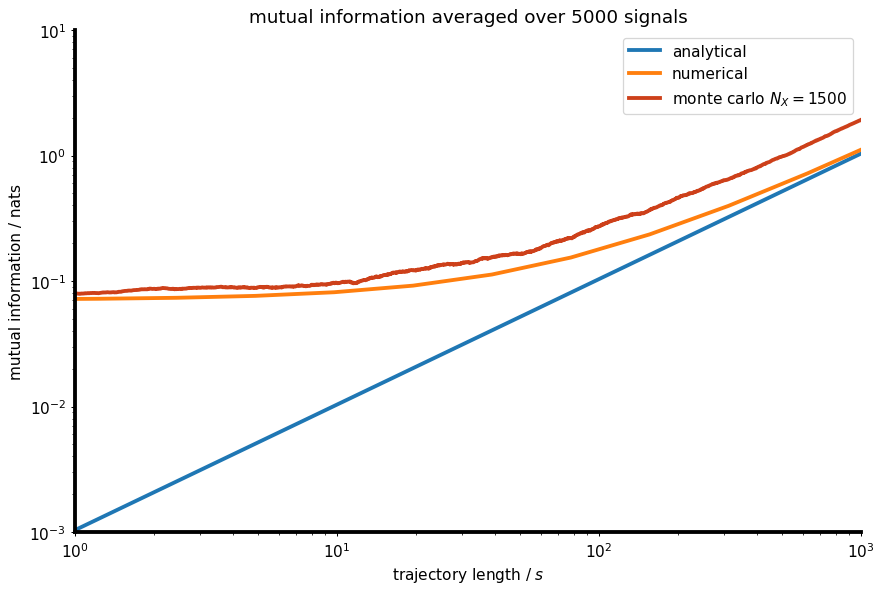

In [12]:
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'TeX Gyre Heros'})
plt.plot(x, theoretical_rate*x, label='analytical', linewidth=3)
plt.plot(numerical_x, numerical, linewidth=3, label='numerical')

plt.plot(x, mi_mean, label='monte carlo $N_X = {}$'.format(num_r), linewidth=3, color='#CD401A')

plt.xlim(1,1250)

ax = plt.gca()
for pos in ['right', 'top']:
    ax.spines[pos].set_visible(False)
    
for pos in ['left', 'bottom']:
    ax.spines[pos].set_linewidth(3)

plt.title('mutual information averaged over {} signals'.format(num_signals))
plt.ylabel('mutual information / nats')
plt.xlabel('trajectory length $/\\; s$')
plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3,1e1)
plt.xlim(1e0,1e3)

plt.gcf().set_size_inches(28/2.54, 18/2.54)
plt.savefig('poster_plot_3.pdf')

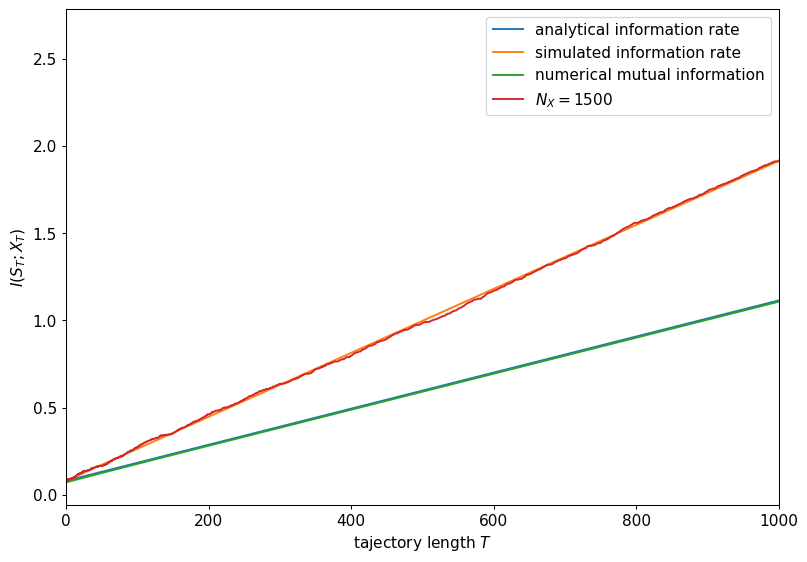

In [14]:
plt.plot(x, theoretical_rate*x + offset, label='analytical information rate')
plt.plot(x, linear(x, rate, offset), label='simulated information rate')
plt.plot(numerical_x, numerical, label='numerical mutual information')
plt.plot(x, mi_mean, label='$N_X={}$'.format(num_r))
plt.ylabel('$I(S_T;X_T)$')
plt.xlabel('tajectory length $T$')
plt.xlim(0,1e3)
plt.legend();

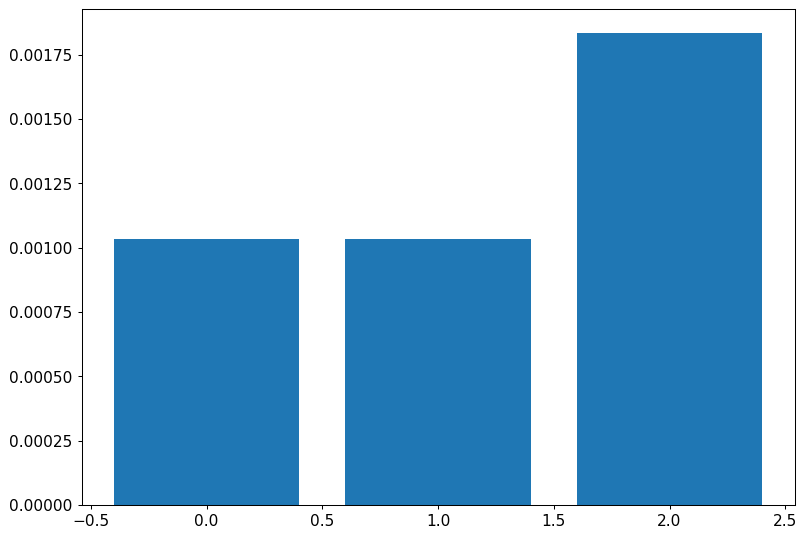

In [15]:
plt.bar(x=np.arange(3), height=[theoretical_rate, rate_from_curve(numerical_x, numerical)[0], rate_from_curve(x, mi_mean)[0]]);

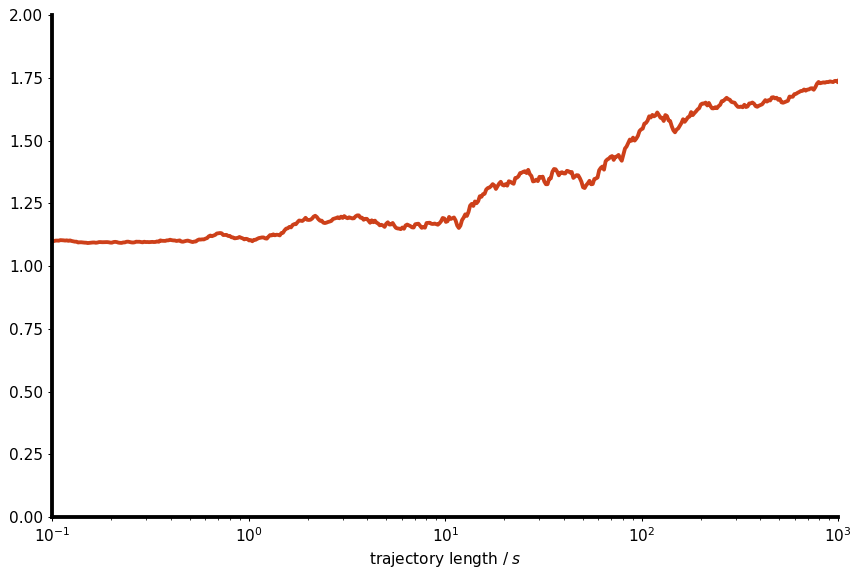

In [16]:
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'TeX Gyre Heros'})
num_int = interpolate.interp1d(numerical_x, numerical, fill_value='extrapolate')
mc_int = interpolate.interp1d(x, mi_mean, fill_value='extrapolate')

xx = np.geomspace(0.1, 1250, 500)

plt.plot(xx, mc_int(xx) / num_int(xx), linewidth=3, color='#CD401A')

plt.xlim(0.1,1000)

ax = plt.gca()
for pos in ['right', 'top']:
    ax.spines[pos].set_visible(False)
    
for pos in ['left', 'bottom']:
    ax.spines[pos].set_linewidth(3)

plt.xlabel('trajectory length $/\\; s$')

plt.xscale('log')
plt.ylim(0,2)

plt.gcf().set_size_inches(28/2.54, 18/2.54)

In [146]:
import mutual_information
import importlib
importlib.reload(mutual_information);

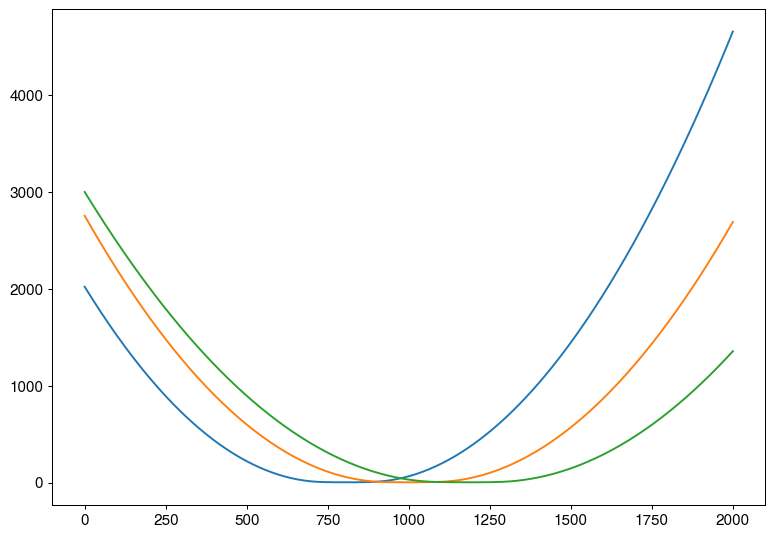

In [193]:
x = np.linspace(0, 2000, 400)
for s in [3000, 4000, 5000]:
    hist = mutual_information.generate_histogram(s, size=80)
    plt.plot(x, -hist.logpdf(x))

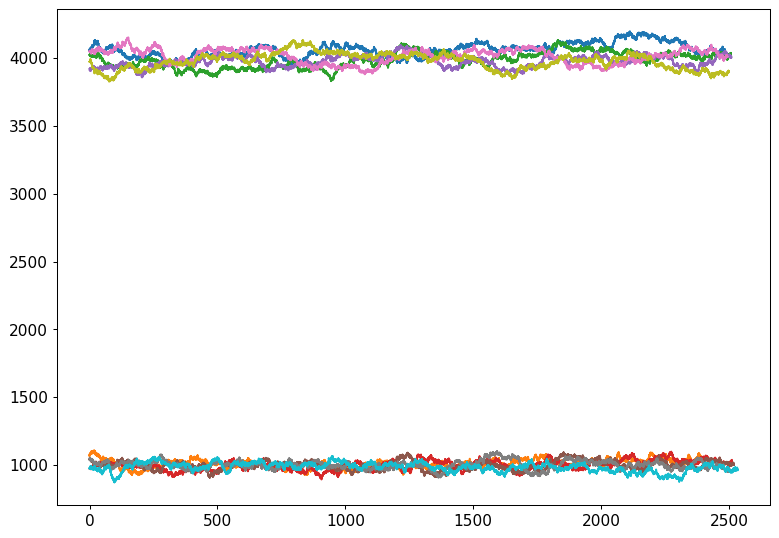

In [17]:
import mutual_information
sig = mutual_information.generate_signals_sim(5)
res = mutual_information.generate_responses(5, sig['timestamps'], sig['components'])
for s in range(5):
    plt.plot(sig['timestamps'][s], sig['components'][s,0])
    plt.plot(res['timestamps'][s], res['components'][s,0])